# Analyzing the Value Premium
February 2022

*July 2022 Note: Since the start of this notebook, the valuation spread between cheap and expensive stocks reverted further to the mean as additional inflationary pressure shifted the government yield curve upwards. Expensive stocks lost ~10% and cheap stocks were fairly flat. The value premium in small stocks has appreciated more than in large stocks.*

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model in their famous paper "The Cross-Section of Expected Stock Returns" that extends William Sharpe's CAPM with a Size Factor (SMB) and a Value Factor (HML):
<br><br>
$$ E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML $$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor empirical performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model from 2015, the standard model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, which in turn points to a set of state variables, it is unclear whether they can indeed proxy the underlying risk factors of Robert Merton's ICAPM. This notebook puts the theory aside and provides a quantitative analysis of the drivers of the value premium and shows that the value premium still exists and is possibly a historically attractive diversifier in the current market environment.

**Table of Contents:**
1. [Descriptive&nbsp;Analysis](#Descriptive&nbsp;Analysis)
2. [Relative&nbsp;Valuations](#Relative&nbsp;Valuations)
3. [Explaining&nbsp;Factors](#Explaining&nbsp;Factors)
4. [Time-Series&nbsp;Predictability](#Time-Series&nbsp;Predictability)
5. [ETF/Stock&nbsp;Selection](#ETF/Stock&nbsp;Selection)

**Data sources:**
* [Kenneth French's Portfolio Database](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
* [Robert Shiller's History of Bond Rates](http://www.econ.yale.edu/~shiller/data.htm)

#### Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import jarque_bera, norm, gaussian_kde
from finance_data import FrenchReader, MSCIReader, shiller_cape

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
shiller_data = shiller_cape()[["10-Year Interest Rate", "CAPE", "CPI"]]
shiller_data["10-Year Interest Rate"] /= 100
ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100
df = pd.concat([ff3, mom, shiller_data], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "10-Year Interest Rate", "CAPE", "CPI"]]
df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,10-Year Interest Rate,CAPE,CPI
1927-01-01,-0.0006,-0.0051,0.0473,NaN,NaN,0.0036,0.0025,0.033400,13.185931,17.500
1927-02-01,0.0418,-0.0025,0.0327,NaN,NaN,-0.0214,0.0026,0.033392,13.633966,17.400
1927-03-01,0.0013,-0.0189,-0.0256,NaN,NaN,0.0361,0.0030,0.033383,14.033258,17.300
1927-04-01,0.0046,0.0049,0.0071,NaN,NaN,0.0430,0.0025,0.033375,14.488222,17.300
1927-05-01,0.0544,0.0146,0.0498,NaN,NaN,0.0300,0.0030,0.033367,15.002347,17.400
...,...,...,...,...,...,...,...,...,...,...
2022-01-01,-0.0625,-0.0593,0.1274,0.0073,0.0773,-0.0250,0.0000,0.017600,36.936758,281.148
2022-02-01,-0.0229,0.0218,0.0309,-0.0212,0.0299,0.0175,0.0000,0.019300,35.287165,283.716
2022-03-01,0.0306,-0.0161,-0.0182,-0.0132,0.0324,0.0298,0.0000,0.021300,34.270844,287.504
2022-04-01,-0.0945,-0.0140,0.0616,0.0351,0.0587,0.0488,0.0000,0.027500,33.889253,289.109


In [4]:
bm_sorted_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
bm_size_sorted_data = FrenchReader("6_Portfolios_2x3").read()

ep_sorted_data = FrenchReader("Portfolios_Formed_on_E-P").read()
ep_size_sorted_data = FrenchReader("6_Portfolios_ME_EP_2x3").read()

cfp_sorted_data = FrenchReader("Portfolios_Formed_on_CF-P").read()
cfp_size_sorted_data = FrenchReader("6_Portfolios_ME_CFP_2x3").read()

## Descriptive&nbsp;Analysis

Starting with descriptive statistics, no factor of Fama/French's five-factor model, except for the equity premium itself, has delivered a significant premium since the publication of the respective model in 1992 and 2015, which questions the models out-of-sample performance to price equity risk.

In [5]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.71% per month with a t-statistic of 3.13.
...the SMB factor returned an average of 0.11% per month with a t-statistic of 0.65.
...the HML factor returned an average of 0.25% per month with a t-statistic of 1.44.

Since 2015,...
...the RMW factor returned an average of 0.36% per month with a t-statistic of 1.72.
...the CMA factor returned an average of 0.13% per month with a t-statistic of 0.55.


While all four factors failed to deliver any premium out-of-sample, I will only discuss the value premium as it is the factor that has recently shown the worst performance and because it has a long tradition in equity markets, ranging back to Benjamin Graham in the early 20th century.

Since 2007, the value premium had its largest drawdown in history and shed about half of its entire cumulative outperformance since 1927 ...

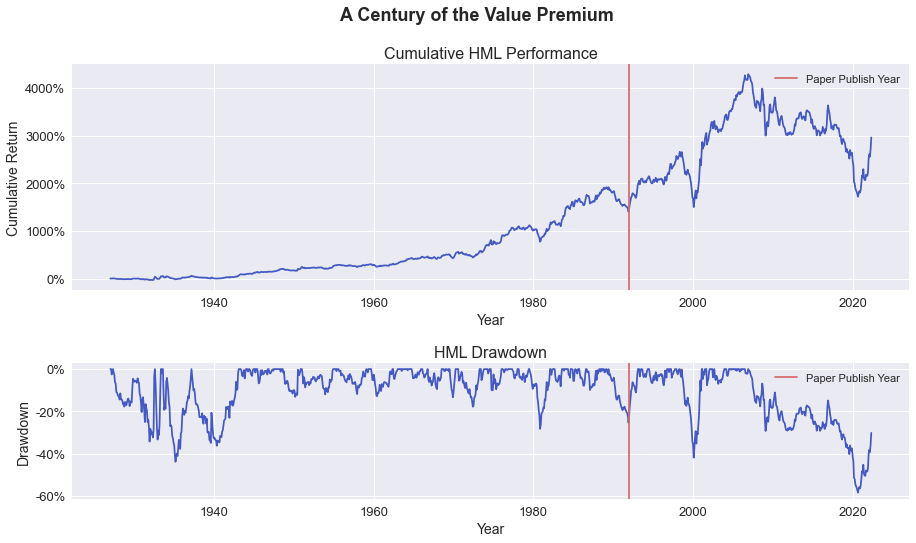

In [6]:
df["HML Cumulative"] = (1+df["HML"]).cumprod()
df["HML Drawdown"] = df["HML Cumulative"] / df["HML Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].plot(df["HML Cumulative"]-1, color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].tick_params(axis="x", labelsize=13)

yticks = np.linspace(0, (df["HML Cumulative"]-1).max() // 10 * 10, 5)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[0].legend(fontsize=11, loc="upper right");

axes[1].plot(df["HML Drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

... and the failure of the value premium was both present in large and small caps, although higher in magnitude in the large cap segment.

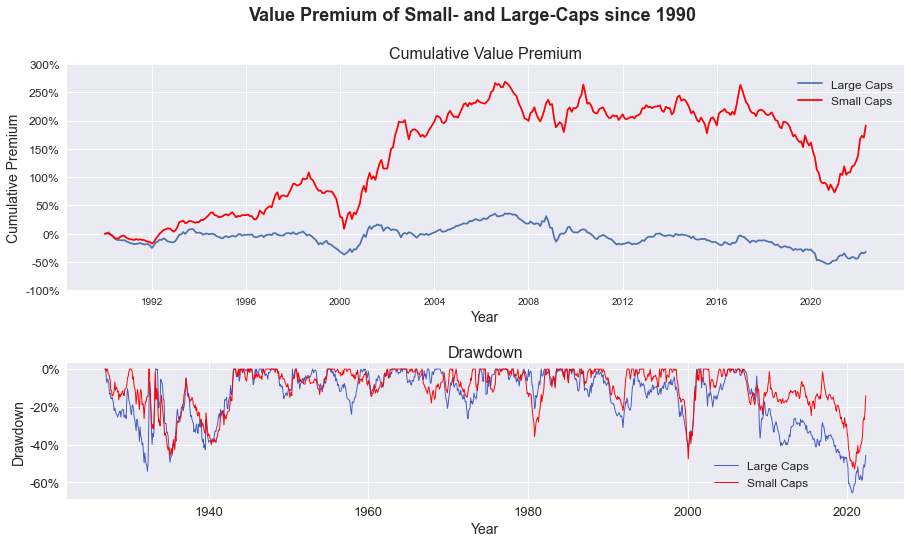

In [7]:
df["Large High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG HiBM"] / 100
df["Large Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG LoBM"] / 100
df["Small High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL HiBM"] / 100
df["Small Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL LoBM"] / 100

df["Large Value Premium"] = df["Large High B/M"] - df["Large Low B/M"] 
df["Large Value Premium Cumulative"] = (1+df["Large Value Premium"]).cumprod()
df["Small Value Premium"] = df["Small High B/M"] - df["Small Low B/M"]
df["Small Value Premium Cumulative"] = (1+df["Small Value Premium"]).cumprod()

df["Large Value Premium Drawdown"] = df["Large Value Premium Cumulative"] / df["Large Value Premium Cumulative"].cummax() - 1
df["Small Value Premium Drawdown"] = df["Small Value Premium Cumulative"] / df["Small Value Premium Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premium of Small- and Large-Caps since 1990", fontsize=18, fontweight="bold")

axes[0].plot((1+df.loc["1990-01-01":, "Large Value Premium"].shift(1).fillna(0)).cumprod()-1, label="Large Caps")
axes[0].plot((1+df.loc["1990-01-01":, "Small Value Premium"].shift(1).fillna(0)).cumprod()-1, label="Small Caps", color="red")

axes[0].set_title("Cumulative Value Premium", size=16)
axes[0].set_xlabel("Year", fontsize=14)
axes[0].set_ylabel("Cumulative Premium", fontsize=14)

yticks1 = axes[0].get_yticks().tolist()
axes[0].set_yticks(yticks1)
axes[0].set_yticklabels([f"{ret:.0%}" for ret in yticks1], fontsize=12)
axes[0].legend(fontsize=12, bbox_to_anchor=(0.1, 0, 0.9, 0.98))

axes[1].plot(df["Large Value Premium Drawdown"], color="#4459c2", linewidth=0.95, label="Large Caps")
axes[1].plot(df["Small Value Premium Drawdown"], color="red", linewidth=0.95, label="Small Caps")

axes[1].set_title("Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12, bbox_to_anchor=(0, 0, 0.9, 0.98));

While some people argue that book values are a flawed measure of valuations as highly profitable technology companies with low capital requirements and hence low book-values become more relevant today, the drawdowns look similar if we take net-earnings or cashflows instead of book-values.
<br>
*(Note that the data for other variables is constrained to a later starting date)*

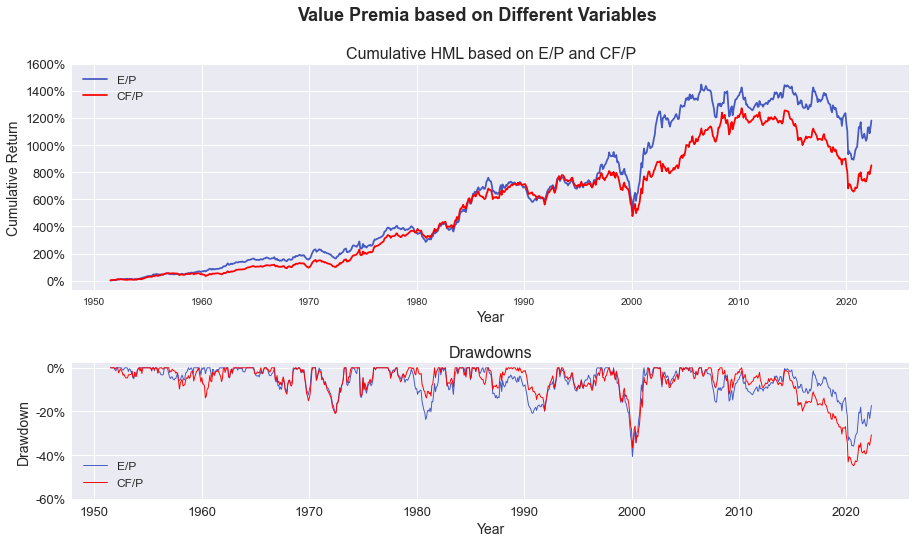

In [8]:
df["Large Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoEP"]) / 100
df["Large Value Premium E/P Cumulative"] = (1+df["Large Value Premium E/P"]).cumprod()
df["Small Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoEP"]) / 100
df["Small Value Premium E/P Cumulative"] = (1+df["Small Value Premium E/P"]).cumprod()

df["HML E/P"] = (df["Large Value Premium E/P"] + df["Small Value Premium E/P"]) / 2
df["HML E/P Cumulative"] = (1+df["HML E/P"]).cumprod()
df["HML E/P Drawdown"] = df["HML E/P Cumulative"] / df["HML E/P Cumulative"].cummax() - 1

df["Large Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoCFP"]) / 100
df["Large Value Premium CF/P Cumulative"] = (1+df["Large Value Premium CF/P"]).cumprod()
df["Small Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoCFP"]) / 100
df["Small Value Premium CF/P Cumulative"] = (1+df["Small Value Premium CF/P"]).cumprod()

df["HML CF/P"] = (df["Large Value Premium CF/P"] + df["Small Value Premium CF/P"]) / 2
df["HML CF/P Cumulative"] = (1+df["HML CF/P"]).cumprod()
df["HML CF/P Drawdown"] = df["HML CF/P Cumulative"] / df["HML CF/P Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, figsize=(15,8), gridspec_kw={'height_ratios': [5,3]})
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premia based on Different Variables", fontsize=18, fontweight="bold")

axes[0].plot(df["HML E/P Cumulative"]-1, color="#4459c2", label="E/P")
axes[0].plot(df["HML CF/P Cumulative"]-1, color="red", label="CF/P")
axes[0].set_title("Cumulative HML based on E/P and CF/P", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
yticks = np.linspace(0, (df["HML E/P Cumulative"]-1).max() // 2 * 2 + 2, 9)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].legend(fontsize=12)

axes[1].plot(df["HML E/P Drawdown"], color="#4459c2", linewidth=0.95, label="E/P")
axes[1].plot(df["HML CF/P Drawdown"], color="red", linewidth=0.95, label="CF/P")

axes[1].set_title("Drawdowns", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12);

However, the recent drawdowns of value premia based on E/P and CF/P start a few years later and are not as large in magnitude as the recent drawdown of the book-value-based value premium.

Looking at the correlations between alternative measures of the value premium, it also becomes clear that it does not matter which fundamental variable we use.

In [9]:
np.round(df[["HML", "HML E/P", "HML CF/P"]].corr(), 2)

,HML,HML E/P,HML CF/P
HML,1.00,0.85,0.83
HML E/P,0.85,1.00,0.89
HML CF/P,0.83,0.89,1.00


To sum it up, the value factor has been terrible recently, no matter of the size of the companies and the variable used. However, there are at least two arguments, considered individually or together, that might invalidate the claim that the recent data points to a vanished value premium:
1. The underperformance is the result of chance.
2. Macroeconomic/fundamentals shifts affected cheap and expensive stocks differently, resulting either in changing valuations or in different unexpected underlying fundamental performances of the companies.

**1. The underperformance is the result of chance**
<br>
Given that all factors carry a sizable amount of risk in the form of volatility, it should be no surprise that a factor, described by a stochastic process with positive mean can underperform for a lengthy period. For example, for an iid normally distributed white noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of 2% that the process realizes a mean return <0 over a period of 15 years. Likewise, the US market portfolio showed multiple periods of 15-year underperformance against bonds.
<br>
So let's analyze the probability that the HML underperformance is due to chance:

Pior to publication in 1992, the Value Premium had delivered an average monthly excess return of

In [10]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
print(f"{prior_mean:.2%}")

0.42%


with a monthly volatility of

In [11]:
prior_std = df.loc[:"1992-01-01", "HML"].std()
print(f"{prior_std:.2%}.")

3.68%.


Assuming a gaussian distribution and stationarity pre- and post publication (i.e. the same mean and volatility pre- and post-publication), we can compute the probability that the value premium returns an average below the realized average post-publication. Given the increasing number of factor ETFs to give retail investors access to alternative factor premia and investors needing some time to fully adapt to new academic research, I do the same for the subsamples of 1997, 2002, 2007 onwards.

In [12]:
print("The respective sample size of each considered subsample is as follows:\n")
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    print(f"The sample size spanning from January {year} to today is {sample_size} months.")

The respective sample size of each considered subsample is as follows:

The sample size spanning from January 1992 to today is 365 months.
The sample size spanning from January 1997 to today is 305 months.
The sample size spanning from January 2002 to today is 245 months.
The sample size spanning from January 2007 to today is 185 months.


Turning to the probabilities, we get the following values.

In [13]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - prior_mean
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.25% per month is 16.33%
For the subsample from January 1997 to today, the probability of an average return less than 0.15% per month is 8.49%
For the subsample from January 2002 to today, the probability of an average return less than 0.05% per month is 2.80%
For the subsample from January 2007 to today, the probability of an average return less than -0.14% per month is 1.05%


So far, one could certainly (and possibly unsurpringly) conclude at some reasonable confidence level that the value premium has a structural break between pre- and post-publication of the paper.
However, running the same for a hypothesis of a zero mean-return post-publication gives the following results:

In [14]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - 0
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.25% per month is 92.53%
For the subsample from January 1997 to today, the probability of an average return less than 0.15% per month is 77.48%
For the subsample from January 2002 to today, the probability of an average return less than 0.05% per month is 60.78%
For the subsample from January 2007 to today, the probability of an average return less than -0.14% per month is 28.04%


Therefore, based on the assumptions and the data, it is not possible to argue that the value premium is dead.
<br>
One issue though is that the empirical distribution of the value premium, like many financial time-series, is non-normal, although I assumed normality until now.

Its skewness is

In [15]:
prior_skew = df.loc[:"1992-01-01", "HML"].skew()
np.round(prior_skew, 2)

2.73

and its excess kurtosis is

In [16]:
prior_kurt = df.loc[:"1992-01-01", "HML"].kurt()
print(np.round(prior_kurt, 2), ",", sep="")

22.91,


both well above that of a normal distribution. Accordingly, a jarque-bera test easily rejects the hypothesis of a normal distribution at the 1% level:

In [17]:
jb = jarque_bera(df.loc[:"1992-01-01", "HML"]).pvalue
print(f"{jb:.2%}")

0.00%


The empirical distribution compared to a normal distribution with same mean and variance also highlights the empirical leptokurtic structure:

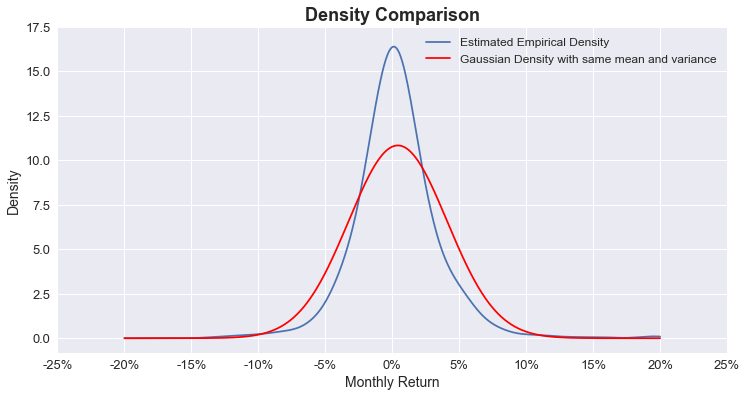

In [18]:
estimated_density = gaussian_kde(df.loc[:"1992-01-01", "HML"])

x = np.linspace(-0.2, 0.2, 1000)
plt.plot(x, estimated_density(x), label="Estimated Empirical Density")
plt.plot(x, norm.pdf(x, prior_mean, prior_std), label="Gaussian Density with same mean and variance", color="red")

plt.title("Density Comparison", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=14)
plt.xlabel("Monthly Return", fontsize=14)

xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{ret:.0%}" for ret in xticks], fontsize=13)
yticks = plt.yticks()[0]
plt.yticks(yticks[1:], yticks[1:], fontsize=13)

plt.legend(fontsize=12);

Therefore, it is important to account for the non-normality and compute the same probabilities before by incorporating the empirical distribution instead of assuming normality. For that, I bootstrap intervals by drawing n times (n=sample size) with replacement from the empirical distribution until January 1992. I do it 100.000 times for each subsample and check the probability of an average return less than the respective realized return by counting the ocurrences and diving it by the total number of bootstrap samples..

In [19]:
series = {}
sample_size = df.loc["1992-01-01":, "HML"].count()
for i in range(100_000):
    series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", "HML"], sample_size))
bootstrapped_df = pd.DataFrame(series)
bootstrapped_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-0.0231,0.0068,-0.0075,0.0327,-0.0183,0.0036,0.0175,0.0146,-0.0152,0.0334,...,0.0028,-0.0078,-0.0042,0.0411,0.0248,0.0272,0.0264,0.0175,-0.0134,-0.0212
1,0.0058,0.0250,-0.0837,0.0060,0.0181,0.0282,0.0440,-0.0053,0.0542,-0.0311,...,-0.0001,-0.0054,-0.0107,0.0224,-0.0094,0.0430,-0.0030,0.0725,-0.0080,0.0423
2,0.0664,-0.0297,-0.0197,0.0169,0.0057,0.0004,-0.0231,0.0032,-0.0231,-0.0074,...,-0.0265,-0.0375,0.0027,0.0012,0.0187,-0.0242,0.0090,0.0067,-0.0003,0.0214
3,0.0479,0.0246,-0.0076,-0.0270,-0.0039,-0.0233,0.0453,0.0108,0.0220,0.0430,...,0.0109,-0.0206,0.0334,0.0176,-0.0161,0.0176,-0.0279,0.0252,0.0061,0.0135
4,0.0008,-0.0009,-0.0079,-0.0527,0.0181,-0.0233,0.0089,0.1559,0.0109,0.0713,...,0.0220,-0.0218,-0.0042,-0.0507,0.0175,0.0168,0.0754,-0.0210,0.0030,-0.0295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,-0.0094,0.0175,0.0633,-0.0159,0.0650,0.0117,0.0507,-0.0109,-0.0244,-0.0049,...,-0.0133,-0.0110,0.0334,0.0031,0.0075,0.0124,-0.0161,0.0116,0.0324,0.0085
361,0.0513,-0.0047,0.0013,0.0464,-0.0111,-0.0213,0.0079,-0.0180,-0.0021,0.0021,...,0.0023,0.0213,-0.0073,-0.0233,-0.0026,0.0061,0.0081,-0.0366,-0.0538,0.0184
362,0.0015,0.0270,0.0040,-0.0405,-0.0230,0.0185,-0.0332,-0.0244,-0.0124,0.0061,...,-0.0014,0.0310,-0.0156,-0.0122,0.0083,0.0062,0.0576,-0.0295,-0.0166,0.0071
363,-0.0107,0.0327,0.0009,0.0130,-0.0333,0.0060,-0.0085,-0.0366,-0.0319,0.0062,...,-0.0291,0.1173,-0.0137,0.0185,-0.0022,-0.0090,0.0310,0.0327,-0.0134,0.0023


In [20]:
for year in (1992, 1997, 2002, 2007):
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    prob = (bootstrapped_df.iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {prob:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.25% per month is 19.22%
For the subsample from January 1997 to today, the probability of an average return less than 0.15% per month is 9.61%
For the subsample from January 2002 to today, the probability of an average return less than 0.05% per month is 5.45%
For the subsample from January 2007 to today, the probability of an average return less than -0.14% per month is 1.45%


And the same results in graphical representation look as follows:

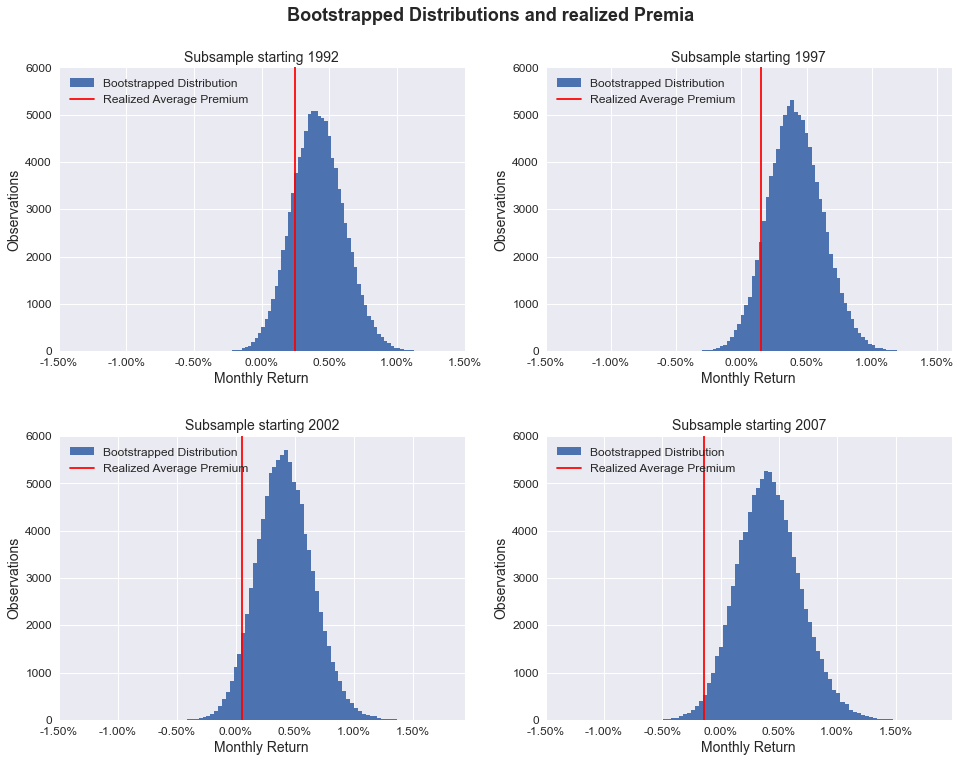

In [21]:
figure, axes = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.3)
figure.suptitle("Bootstrapped Distributions and realized Premia", fontsize=18, fontweight="bold", y=0.95)

for year, (x, y) in zip((1992, 1997, 2002, 2007), ((0,0), (0,1), (1,0), (1,1))):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    axes[x,y].hist(bootstrapped_df.iloc[:sample_size, :].mean(), bins=70, label="Bootstrapped Distribution")
    axes[x,y].axvline(df.loc[f"{year}-01-01":, "HML"].mean(), color="red", label="Realized Average Premium")
    
    axes[x,y].set_title(f"Subsample starting {year}", fontsize=14)
    axes[x,y].set_xlabel("Monthly Return", fontsize=14)
    axes[x,y].set_ylabel("Observations", fontsize=14)
    
    xticks = np.linspace(-0.015, 0.015, 7)
    axes[x,y].set_xticks(xticks)
    axes[x,y].set_xticklabels([f"{ret:.2%}" for ret in xticks], fontsize=12)
    yticks = axes[x,y].get_yticks().tolist()
    axes[x,y].set_yticks(yticks)
    axes[x,y].set_yticklabels([int(obs) for obs in yticks], fontsize=12)
    
    axes[x,y].legend(fontsize=12)

Although the probabilities are a bit higher than when I assumed normality, the main message remains the same and the post-publication value premium is either a statistical outlier or the process exhibits a structural mean-shift. However, as I have shown, the hypothesis that the post-publication mean return is zero cannot be rejected (which can also be seen if we shift the boostrapped distributions to the left so that it has a zero mean). Therefore, looking at the mere data, there is no indication of a dead value premium.

## Relative&nbsp;Valuations

While a basket of stocks with the same characteristics (e.g. same magnitude of market beta) should deliver its expected premium over the long term, it can deviate quite a lot from that over the shorter term for various reasons. Valuations of stocks change continuously as the business cycle affects the overall risk aversion, new news getting priced in and many other factors.
<br>
The shorter the period, the higher is the effect of changing valuations compared to the embedded premium on returns.
For example, the daily equity premium is a few basis points and the volatility of around 100 basis points overweighs, but over decades, positive and negative shocks cancel each other out and the premium overweighs. For example, following the financial crisis 2008/09, the realized US equity premium was well above its historical average since it benefited quite a lot from changes in valuations.

The US equity premium from 1927 to today was

In [22]:
equity_premium = df["Mkt-RF"].mean()*12
print(f"{equity_premium:.2%},")

8.08%,


while the average from 2009 to today was

In [23]:
equity_premium_recent = df.loc["2009-01-01": , "Mkt-RF"].mean()*12
print(f"{equity_premium_recent:.2%},")

14.14%,


or

In [24]:
sigma = ((df["Mkt-RF"].std() * np.sqrt(12)) / np.sqrt(df.loc["2009-01-01": , "Mkt-RF"].count()/12))
np.round((equity_premium_recent - equity_premium) / sigma, 2)

1.2

standard deviations above its expected value using the full sample mean and assuming normality.

Accordingly, a large portion of US stock returns since 2009 have been the result of changing valuations, measured in terms of the [CAPE](https://www.nber.org/system/files/working_papers/w8221/w8221.pdf), and not by fundamental drivers such as abnormally high earnings growth (expectations) or dividends.

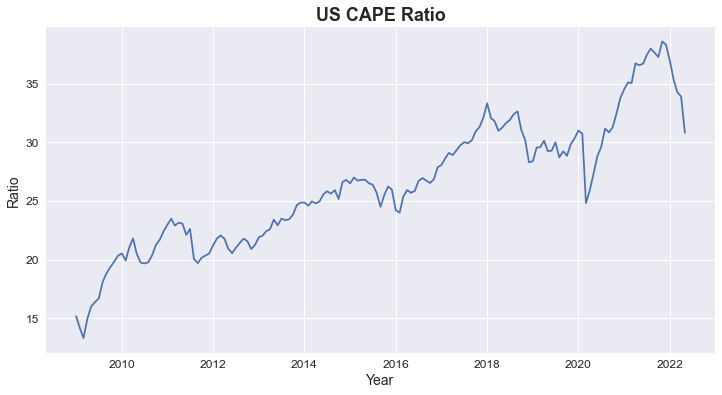

In [25]:
plt.plot(df.loc["2009-01-01":, "CAPE"])

plt.title("US CAPE Ratio", fontsize=18, fontweight="bold")
plt.ylabel("Ratio", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In a similar fashion, the realized value premium is the result of three factors:
1. The difference of the embedded ex-ante risk premia between low-valued and high-valued stocks
2. The change in relative valuations due to changing expectations
3. Unexpected fundamental changes that do not affect the relative valuations, e.g. lower realized than expected earnings growth that do not affect expectations going forward and hence also not affect relative valuations
<br>

Again, over a long enough sample, (2) and (3) should have little effect, but over the short term, they can be the main driver of the value premium.

If we take a look at the relative valuations of stocks with high book-to-market ratios and those with low book-to-market ratios, both in small- and large-caps, we can see that relative valuations increased dramatically since the start of the HML drawdown in January 2007 with relative valuations widening between 200% and 250%.

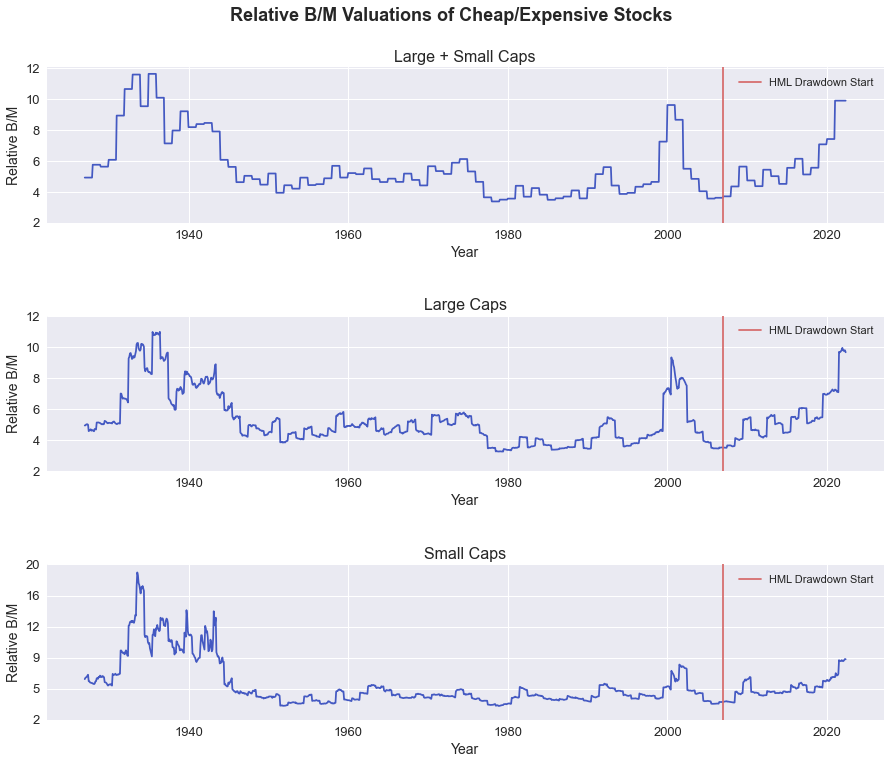

In [26]:
df["High B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Hi 30"]
df["Low B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Lo 30"]
df["Large High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["BIG HiBM"]
df["Large Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["BIG LoBM"]
df["Small High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["SMALL HiBM"]
df["Small Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE/ME"]["SMALL LoBM"]

df["Valuation Spread All"] = (df["High B/M Ratio"] / df["Low B/M Ratio"]).ffill()
df["Valuation Spread Large"] = df["Large High B/M Ratio"] / df["Large Low B/M Ratio"]
df["Valuation Spread Small"] = df["Small High B/M Ratio"] / df["Small Low B/M Ratio"]

figure, axes = plt.subplots(3, figsize=(15,12))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative B/M Valuations of Cheap/Expensive Stocks", fontsize=18, fontweight="bold", y=0.95)

axes[0].plot(df["Valuation Spread All"], color="#4459c2")
axes[0].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[0].set_title("Large + Small Caps", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Relative B/M", size=14)
axes[0].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, df["Valuation Spread All"].max() // 2 * 2 + 2, int(df["Valuation Spread All"].max() // 2)+1)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[0].legend(fontsize=11, loc="upper right");

axes[1].plot(df["Valuation Spread Large"], color="#4459c2")
axes[1].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[1].set_title("Large Caps", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Relative B/M", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, df["Valuation Spread Large"].max() // 2 * 2 + 2, int(df["Valuation Spread Large"].max() // 2)+1)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

axes[2].plot(df["Valuation Spread Small"], color="#4459c2")
axes[2].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[2].set_title("Small Caps", size=16)
axes[2].set_xlabel("Year", size=14)
axes[2].set_ylabel("Relative B/M", size=14)
axes[2].tick_params(axis="x", labelsize=13)

yticks = np.linspace(2, df["Valuation Spread Small"].max() // 2 * 2 + 2, int(df["Valuation Spread Small"].max() // 3))
axes[2].set_yticks(yticks)
axes[2].set_yticklabels([int(tick) for tick in yticks], size=13)

axes[2].legend(fontsize=11, loc="upper right");

The picture looks similar when using net-earnings or cashflows as the fundamental variable instead of book-values, although the widening is not as significant as for book-values.

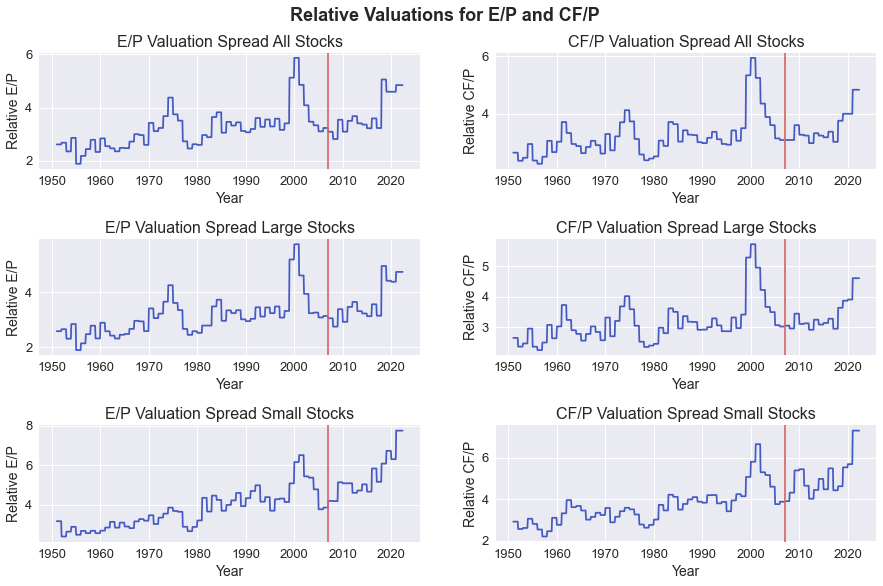

In [27]:
df["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
df["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]
df["E/P Valuation Spread All"] = (df["High E/P Ratio"] / df["Low E/P Ratio"]).ffill()

df["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
df["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
df["E/P Valuation Spread Large"] = (df["Large High E/P Ratio"] / df["Large Low E/P Ratio"]).ffill()

df["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
df["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]
df["E/P Valuation Spread Small"] = (df["Small High E/P Ratio"] / df["Small Low E/P Ratio"]).ffill()

df["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
df["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]
df["CF/P Valuation Spread All"] = (df["High CF/P Ratio"] / df["Low CF/P Ratio"]).ffill()

df["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
df["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
df["CF/P Valuation Spread Large"] = (df["Large High CF/P Ratio"] / df["Large Low CF/P Ratio"]).ffill()

df["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
df["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]
df["CF/P Valuation Spread Small"] = (df["Small High CF/P Ratio"] / df["Small Low CF/P Ratio"]).ffill()


figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative Valuations for E/P and CF/P", fontsize=18, fontweight="bold", y=0.95)

for row, dataset in enumerate((
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small"
)):

    axes[row, 0].plot(df[dataset], color="#4459c2")
    axes[row, 0].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 0].set_title(f"{dataset} Stocks", size=16)
    axes[row, 0].set_xlabel("Year", size=14)
    axes[row, 0].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 0].tick_params(axis="both", labelsize=13)

for row, dataset in enumerate((
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
)):
    axes[row, 1].plot(df[dataset], color="#4459c2")
    axes[row, 1].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 1].set_title(f"{dataset} Stocks", size=16)
    axes[row, 1].set_xlabel("Year", size=14)
    axes[row, 1].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 1].tick_params(axis="both", labelsize=13)

## Explaining&nbsp;Factors

This indicates that the *fundamental* value premium might not have been as bad as it first seems. To verfiy this, let's look at the value premium, assuming that valuation spreads between expensive and cheap stocks had been constant.

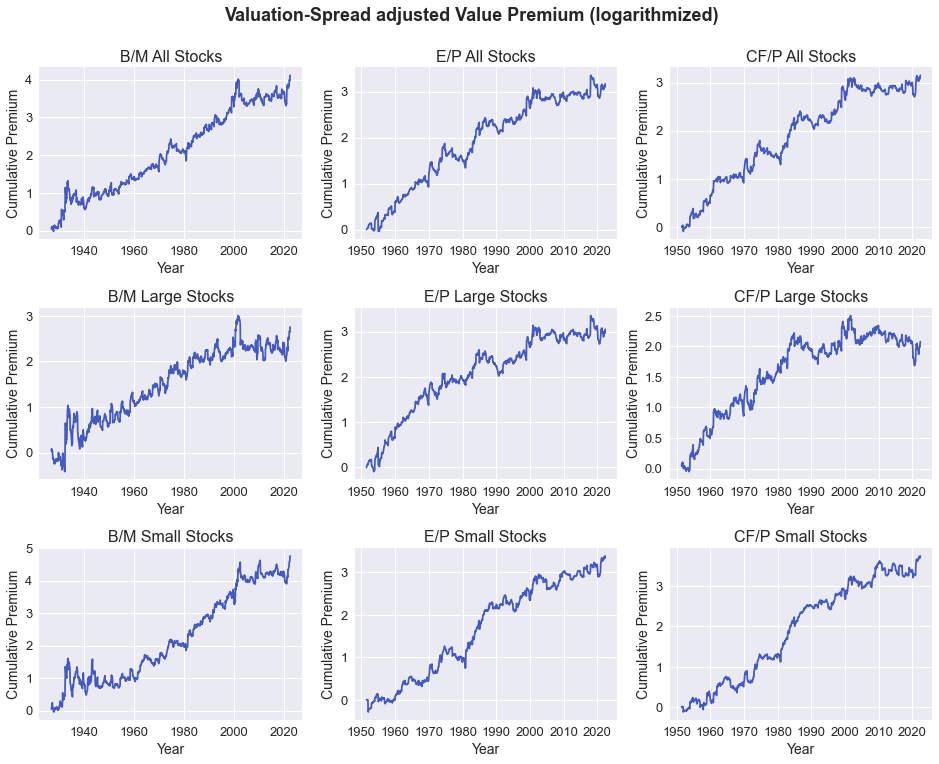

In [28]:
df["HML Adjusted Cumulative"] = df["HML Cumulative"] * df["Valuation Spread All"] / df["Valuation Spread All"][0]
df["Large Value Premium Adjusted Cumulative"] = df["Large Value Premium Cumulative"] * df["Valuation Spread Large"] / df["Valuation Spread Large"].dropna()[0]
df["Small Value Premium Adjusted Cumulative"] = df["Small Value Premium Cumulative"] * df["Valuation Spread Small"] / df["Valuation Spread Small"].dropna()[0]

df["HML E/P Adjusted Cumulative"] = df["HML E/P Cumulative"] * df["E/P Valuation Spread All"] / df["E/P Valuation Spread All"].dropna()[0]
df["Large Value Premium E/P Adjusted Cumulative"] = df["Large Value Premium E/P Cumulative"] * df["E/P Valuation Spread Large"] / df["E/P Valuation Spread Large"].dropna()[0]
df["Small Value Premium E/P Adjusted Cumulative"] = df["Small Value Premium E/P Cumulative"] * df["E/P Valuation Spread Small"] / df["E/P Valuation Spread Small"].dropna()[0]

df["HML CF/P Adjusted Cumulative"] = df["HML E/P Cumulative"] * df["CF/P Valuation Spread All"] / df["CF/P Valuation Spread All"].dropna()[0]
df["Large Value Premium CF/P Adjusted Cumulative"] = df["Large Value Premium CF/P Cumulative"] * df["CF/P Valuation Spread Large"] / df["CF/P Valuation Spread Large"].dropna()[0]
df["Small Value Premium CF/P Adjusted Cumulative"] = df["Small Value Premium CF/P Cumulative"] * df["CF/P Valuation Spread Small"] / df["CF/P Valuation Spread Small"].dropna()[0]

for series in (
    "HML Adjusted Cumulative",
    "Large Value Premium Adjusted Cumulative",
    "Small Value Premium Adjusted Cumulative",
    "HML E/P Adjusted Cumulative",
    "Large Value Premium E/P Adjusted Cumulative",
    "Small Value Premium E/P Adjusted Cumulative",
    "HML CF/P Adjusted Cumulative",
    "Large Value Premium CF/P Adjusted Cumulative",
    "Small Value Premium CF/P Adjusted Cumulative"
):
    df[series.strip(" Cumulative")] = df[series].pct_change()

figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,12))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Valuation-Spread adjusted Value Premium (logarithmized)", fontsize=18, fontweight="bold", y=0.95)

for row, (dataset, title) in enumerate(
    zip(
        ("HML Adjusted Cumulative", "Large Value Premium Adjusted Cumulative", "Small Value Premium Adjusted Cumulative"),
        ("B/M All Stocks", "B/M Large Stocks", "B/M Small Stocks")
    )
):
    axes[row, 0].plot(np.log(df[dataset]), color="#4459c2")
    axes[row, 0].set_title(title, size=16)
    axes[row, 0].set_xlabel("Year", size=14)
    axes[row, 0].set_ylabel(f"Cumulative Premium", size=14)
    axes[row, 0].tick_params(axis="both", labelsize=13)

for row, (dataset, title) in enumerate(
    zip(
        ("HML E/P Adjusted Cumulative", "Large Value Premium E/P Adjusted Cumulative", "Small Value Premium E/P Adjusted Cumulative"),
        ("E/P All Stocks", "E/P Large Stocks", "E/P Small Stocks")
    )
):
    axes[row, 1].plot(np.log(df[dataset]), color="#4459c2")
    axes[row, 1].set_title(title, size=16)
    axes[row, 1].set_xlabel("Year", size=14)
    axes[row, 1].set_ylabel(f"Cumulative Premium", size=14)
    axes[row, 1].tick_params(axis="both", labelsize=13)

for row, (dataset, title) in enumerate(
    zip(
        ("HML CF/P Adjusted Cumulative", "Large Value Premium CF/P Adjusted Cumulative", "Small Value Premium CF/P Adjusted Cumulative"),
        ("CF/P All Stocks", "CF/P Large Stocks", "CF/P Small Stocks")
    )
):
    axes[row, 2].plot(np.log(df[dataset]), color="#4459c2")
    axes[row, 2].set_title(title, size=16)
    axes[row, 2].set_xlabel("Year", size=14)
    axes[row, 2].set_ylabel(f"Cumulative Premium", size=14)
    axes[row, 2].tick_params(axis="both", labelsize=13)

At first glance, the past 10 to 20 years have not been an outlier once the value premium is adjusted for valuation changes and only the B/M and CF/P constructed premium in large cap stocks showed some weakness.
<br>
To test whether the adjusted premia post-publication lie within expected intervals, I repeat the previous bootstrap sampling with the nine valuation-spread adjusted premia using the same start dates and drawing from each empirical distribution until January 1992.
<br>
*(Sampling requires some minutes)*

In [29]:
bootstrapped_premia = {}
for premium in (
    "HML Adjusted",
    "Large Value Premium Adjusted",
    "Small Value Premium Adjusted",
    "HML E/P Adjusted",
    "Large Value Premium E/P Adjusted",
    "Small Value Premium E/P Adjusted",
    "HML CF/P Adjusted",
    "Large Value Premium CF/P Adjusted",
    "Small Value Premium CF/P Adjusted"
):
    print(premium)
    series = {}
    sample_size = df.loc["1992-01-01":, premium].count()
    for i in range(100_000):
        series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", premium], sample_size))
    bootstrapped_premia[premium] = pd.DataFrame(series)

HML Adjusted
Large Value Premium Adjusted
Small Value Premium Adjusted
HML E/P Adjusted
Large Value Premium E/P Adjusted
Small Value Premium E/P Adjusted
HML CF/P Adjusted
Large Value Premium CF/P Adjusted
Small Value Premium CF/P Adjusted


In [30]:
probabilities = pd.DataFrame()
probabilities.index.name = "Subsample starting in ..."
for premium in (
    "HML Adjusted",
    "Large Value Premium Adjusted",
    "Small Value Premium Adjusted",
    "HML E/P Adjusted",
    "Large Value Premium E/P Adjusted",
    "Small Value Premium E/P Adjusted",
    "HML CF/P Adjusted",
    "Large Value Premium CF/P Adjusted",
    "Small Value Premium CF/P Adjusted"
):
    for year in (1992, 1997, 2002, 2007):
        realized_mean = df.loc[f"{year}-01-01":, premium].mean()
        sample_size = df.loc[f"{year}-01-01":, premium].count()
        prob = (bootstrapped_premia[premium].iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
        probabilities.loc[year, premium] = prob

The probabilities of a mean return less than the respective realized return for each subsample and for each valuation-spread adjusted premium using the empirical distribution until January 1992 are as follows:

In [31]:
probabilities.applymap(lambda x: f"{x:.2%}")

,HML Adjusted,Large Value Premium Adjusted,Small Value Premium Adjusted,HML E/P Adjusted,Large Value Premium E/P Adjusted,Small Value Premium E/P Adjusted,HML CF/P Adjusted,Large Value Premium CF/P Adjusted,Small Value Premium CF/P Adjusted
Subsample starting in ...,,,,,,,,,
1992,57.85%,40.72%,58.75%,29.40%,30.59%,30.26%,29.65%,20.21%,31.38%
1997,58.09%,44.71%,57.43%,25.76%,24.21%,35.46%,26.46%,15.64%,34.53%
2002,22.00%,20.07%,28.93%,14.11%,12.29%,21.93%,10.82%,7.86%,21.82%
2007,51.92%,46.34%,42.96%,21.69%,17.45%,40.58%,21.24%,15.06%,38.46%


Except for some subsamples starting before the tech bubble in 2000, the probabilities are <50%, implying that the realized subsample premia have been less than the empirical mean pre-publication. More importantly though is that all probabilities fall within standard intervals and post-publication valuation-adjusted premia have **not** been a tail event.

**3. Macroeconomic/Fundamental shifts affected cheap and expensive stocks differently**
<br>

Using the valuation-spread adjusted premium for analysis would be biased if there were shifts in underlying factors that justify the widening spread of expensive and cheap stocks or if investors price in widening gaps in those factors that are expected to materialize in the future (e.g. expensive stocks become more profitable while the profitability of cheap stocks remains on the same level).
<br>
Then, the widening valuation spread would be explainable and there could well be a structural break in the mean return pre- and post-publication as I have shown earlier.
<br>
I will lay out the main drivers of valuation spreads and argue that a large part of the widening of the value spread is not explained by those drivers.

Starting with the simple pricing equation, any asset price should equal the sum of all excess cashflows it will generate during its lifetime, discounted to the present.
<br>
<br>
$$ Price = \sum \limits_{i=1} ^{\infty} \frac{Free\;Cashflow_i}{(1+Discount\;Rate_i)^{i}} $$
<br>
<br>
Assuming a flat yield curve, a constant growth rate of free-cashflows and that the discount rate is higher than the growth rate, the resulting geometric series can be simplified to
<br>
<br>
$$ Price = \frac{Free\;Cashflow}{Discount\;Rate-Growth\;Rate} $$
<br>
<br>
The discount rate of any asset consists of its risk premium and the rate one would get on a riskless asset.
<br>
<br>
$$ Price = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Growth\;Rate} $$
<br>
<br>
The growth rate of the free cashflows is governed by the reinvestment rate scaled by the profitability. If all cashflows are reinvested with a return on investment of 10%, then the growth rate has to be 10%. Likewise, if only 50% of cashflows are reinvested, the growth rate would be 5%.
<br>
<br>
$$ Price = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity} $$
<br>
<br>
Rearranging gives
<br>
<br>
$$ \frac{Free\;Cashflow}{Price} = Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity $$
<br>
<br>
Since cashflows and book-values are related via the return on equity (assuming 100% cashflow conversion), the equation with B/M instead of CF/P is
<br>
<br>
$$ \frac{Book\;Value}{Price} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{Return\;On\;Equity} $$
<br>
<br>
The valuation spread between cheap and expensive stocks is then
<br>
<br>
$$ \frac{B/M_{Cheap}}{B/M_{Expensive}} = (\frac{Riskfree\;Rate+Risk\;Premium_{Cheap}-Reinvestment\;Rate_{Cheap}*Return\;On\;Equity_{Cheap}}{Riskfree\;Rate+Risk\;Premium_{Expensive}-Reinvestment\;Rate_{Expensive}*Return\;On\;Equity_{Expensive}}) * \frac{Return\;On\;Equity_{Expensive}}{Return\;On\;Equity_{Cheap}} $$

## Time-Series&nbsp;Predictability

## ETF/Stock&nbsp;Selection